# NYC 택시 날씨별 수요 분석

- NYC의 2024년 1월부터 6월까지의 Yellow cab 데이터를 수집했다.
- 그에 맞는 기간의 NYC 날씨 데이터도 수집했다.
- 이를 통해 기온, 날씨(맑을 때, 눈이 올 때, 비가 올 때), 기압에 따라 사람들이 택시를 자주 타는지, 각각의 상황에 한번 탈 때 이동한 거리와 팁을 분석한다.
- 이는 NYC 지역 택시 기사들이 날씨에 따라 유동적으로 움직이는데 도움이 될 수 있으며, 운행 전략을 세우거나 수익 극대화를 위한 의사결정에 실질적인 인사이트를 제공할 수 있다.

In [ ]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import NumericType
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    to_date, col, count, when, isnan, mean, round as spark_round,
    first, unix_timestamp, expr, lower, avg, hour
)
from functools import reduce
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import builtins

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("Yellow Taxi Data Loader") \
    .getOrCreate()

# 데이터 경로 설정
base_path = "/data"
months = ["01", "02", "03", "04", "05", "06"]
parquet_paths = [f"{base_path}/yellow_tripdata_2024-{m}.parquet" for m in months]

# Parquet 파일을 순차적으로 읽고 병합
df_list = []
for path in parquet_paths:
    print(f"Loading: {path}")
    df = spark.read.parquet(path)
    df_list.append(df)

# 병합
taxi_df = reduce(DataFrame.unionByName, df_list)
print(f"병합된 택시 데이터: {taxi_df.count():,} rows")

# 시간 형식 변환 및 날짜 추출
taxi_df = taxi_df.withColumn("tpep_pickup_datetime", taxi_df["tpep_pickup_datetime"].cast("timestamp"))
taxi_df = taxi_df.withColumn("pickup_date", to_date("tpep_pickup_datetime"))

# 결과 확인
taxi_df.select("tpep_pickup_datetime", "pickup_date").show(5)

Loading: /data/yellow_tripdata_2024-01.parquet
Loading: /data/yellow_tripdata_2024-02.parquet
Loading: /data/yellow_tripdata_2024-03.parquet
Loading: /data/yellow_tripdata_2024-04.parquet
Loading: /data/yellow_tripdata_2024-05.parquet
Loading: /data/yellow_tripdata_2024-06.parquet
병합된 택시 데이터: 20,332,093 rows
+--------------------+-----------+
|tpep_pickup_datetime|pickup_date|
+--------------------+-----------+
| 2024-01-01 00:57:55| 2024-01-01|
| 2024-01-01 00:03:00| 2024-01-01|
| 2024-01-01 00:17:06| 2024-01-01|
| 2024-01-01 00:36:38| 2024-01-01|
| 2024-01-01 00:46:51| 2024-01-01|
+--------------------+-----------+
only showing top 5 rows


## 택시 데이터 결측치 확인 및 처리

In [ ]:
# 전체 row 수
total_rows = taxi_df.count()

# 각 컬럼 타입 확인
schema = taxi_df.schema

# 결측치 계산 조건 분기
missing_exprs = []
for field in schema:
    col_name = field.name
    data_type = field.dataType
    if isinstance(data_type, NumericType):
        # 숫자형: NaN + Null 체크
        expr = count(when(col(col_name).isNull() | isnan(col(col_name)), col_name)).alias(col_name)
    else:
        # 문자열 등: Null만 체크
        expr = count(when(col(col_name).isNull(), col_name)).alias(col_name)
    missing_exprs.append(expr)

# 결측치 개수 계산
missing_counts = taxi_df.select(missing_exprs)
missing_dict = missing_counts.collect()[0].asDict()

# 결측치가 있는 컬럼만 정리
missing_list = [
    (col_name, cnt, cnt / total_rows * 100)
    for col_name, cnt in missing_dict.items()
    if cnt > 0
]

# Spark DataFrame으로 변환
missing_summary = spark.createDataFrame(missing_list, ["column_name", "missing_count", "missing_percentage"])

# 정렬 및 출력
missing_summary.orderBy("missing_count", ascending=False).show(truncate=False)

+--------------------+-------------+------------------+
|column_name         |missing_count|missing_percentage|
+--------------------+-------------+------------------+
|RatecodeID          |1975985      |9.718551848056174 |
|congestion_surcharge|1975985      |9.718551848056174 |
|passenger_count     |1975985      |9.718551848056174 |
|store_and_fwd_flag  |1975985      |9.718551848056174 |
|Airport_fee         |1975985      |9.718551848056174 |
+--------------------+-------------+------------------+



In [ ]:
# 평균값으로 대체 (숫자형 컬럼)
for c in ["passenger_count", "Airport_fee", "congestion_surcharge"]:
    avg_val = taxi_df.select(mean(col(c))).first()[0]
    if c == "passenger_count":
        avg_val = int(builtins.round(avg_val))  # PySpark round 아님
    taxi_df = taxi_df.withColumn(c, when(col(c).isNull(), avg_val).otherwise(col(c)))

# 최빈값으로 대체 (범주형 컬럼)
for c in ["RatecodeID", "store_and_fwd_flag"]:
    mode_val = taxi_df.groupBy(c).count().orderBy(col("count").desc()).first()[0]
    taxi_df = taxi_df.withColumn(c, when(col(c).isNull(), mode_val).otherwise(col(c)))

# 결측치 확인
total_rows = taxi_df.count()
missing_exprs = []

for field in taxi_df.schema:
    col_name = field.name
    if isinstance(field.dataType, NumericType):
        expr_obj = count(when(col(col_name).isNull() | isnan(col(col_name)), col_name)).alias(col_name)
    else:
        expr_obj = count(when(col(col_name).isNull(), col_name)).alias(col_name)
    missing_exprs.append(expr_obj)

# 결측치 집계 및 비율 계산
missing_counts_df = taxi_df.select(missing_exprs).toPandas().T
missing_counts_df.columns = ["Missing Count"]
missing_counts_df["Missing Percentage (%)"] = (missing_counts_df["Missing Count"] / total_rows) * 100
missing_counts_df = missing_counts_df[missing_counts_df["Missing Count"] > 0].sort_values("Missing Count", ascending=False)

# 결과 출력
display(missing_counts_df)

,Missing Count,Missing Percentage (%)


## 택시 이용 평균 시간과 이동거리

In [ ]:
from pyspark.sql.functions import col, unix_timestamp, round, mean

# trip_duration (분 단위) 계산
taxi_df = taxi_df.withColumn(
    "trip_duration",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)

# 평균 이용 시간 계산
avg_duration = taxi_df.select(mean("trip_duration")).first()[0]
print(f"평균 택시 이용 시간: {avg_duration:.2f} 분")

# 평균 이동 거리 계산
avg_distance = taxi_df.select(mean("trip_distance")).first()[0]
print(f"평균 이동 거리: {avg_distance:.2f} 마일")

[Stage 338:===================================================>   (45 + 3) / 48]

평균 택시 이용 시간: 16.88 분
평균 이동 거리: 4.70 마일


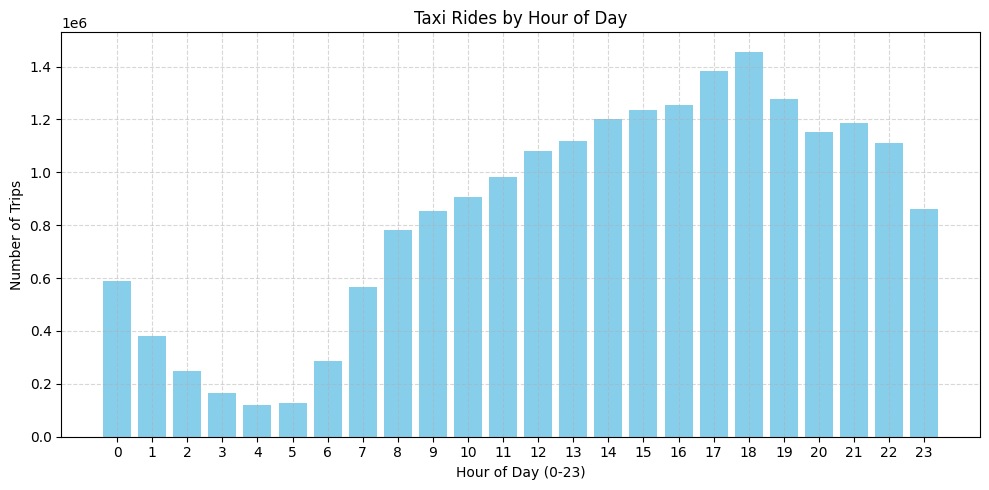

In [ ]:
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans" 
plt.rcParams["axes.unicode_minus"] = False

# Extract hour from pickup datetime
taxi_df = taxi_df.withColumn("pickup_hour", hour("tpep_pickup_datetime"))

# Count trips per hour
hourly_counts = (
    taxi_df.groupBy("pickup_hour")
    .count()
    .orderBy("pickup_hour")
    .toPandas()
)

# Visualization
plt.figure(figsize=(10, 5))
plt.bar(hourly_counts["pickup_hour"], hourly_counts["count"], color="skyblue")
plt.title("Taxi Rides by Hour of Day")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## 시간대별 택시 이용횟수 분석

- 아침 시간대부터 택시 이용 횟수가 증가하는 모습을 보이다가 퇴근 시간대(18시)에 피크를 찍는 것을 확인할 수 있음
    - 뉴욕 사람들은 출근할 때보다 퇴근할 때 택시를 더 많이 이용하는 것을 알 수 있음
    - 새벽 시간대(02시 ~ 05시)에 사람들이 가장 택시를 이용하지 않는 것을 볼 수 있는데, 이는 대중 교통 이용자가 적은 심야 시간대의 특성을 보여줌
    - 전반적으로 오후 시간대에 택시를 많이 타는 것으로 확인할 수 있으며, 상업 활동과 퇴근 시간에 택시를 주로 사용하는 것을 알 수 있음

In [ ]:
# CSV 파일을 Spark DataFrame으로 불러오기
weather_df = spark.read.option("header", True).option("inferSchema", True).csv("/data/NYC_weather.csv")

weather_df.show(5)

+-------------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+-------------------+-------------------+---------+--------------------+--------------------+-----------------+--------------------+
|         name|  datetime|tempmax|tempmin|temp|feelslikemax|feelslikemin|feelslike| dew|humidity|precip|precipprob|precipcover|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|            sunrise|             sunset|moonphase|          conditions|         description|             icon|            stations|
+-------------+----------+-------+-------+----+------------+------------+---------+----+--------+------+----------+-----------+----------+----+---------+--------+---------+-------+----------------+---------

## 날씨 데이터 결측치 확인 및 처리

In [ ]:
# 전체 행 수
total_rows = weather_df.count()

# 컬럼별 데이터 타입 확인
column_info = weather_df.dtypes  

# 컬럼별 결측치 계산식 정의
missing_exprs = []
for c, dtype in column_info:
    if dtype in ["double", "float", "int", "bigint", "smallint"]:
        expr = count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
    else:
        expr = count(when(col(c).isNull(), c)).alias(c)
    missing_exprs.append(expr)

# 결측치 개수 계산
missing_counts = weather_df.select(missing_exprs)

# stack을 이용해 long 포맷으로 변환
stack_expr = "stack({0}, {1}) as (column_name, missing_count)".format(
    len(missing_exprs),
    ", ".join([f"'{c[0]}', {c[0]}" for c in column_info])
)
missing_long = missing_counts.selectExpr(stack_expr)

# 결측치 비율 계산
missing_result = missing_long.withColumn(
    "missing_percentage",
    (col("missing_count") / total_rows) * 100
)

# 결측치가 존재하는 컬럼만 출력
missing_result.filter(col("missing_count") > 0).orderBy(col("missing_count").desc()).show(truncate=False)

+-----------+-------------+------------------+
|column_name|missing_count|missing_percentage|
+-----------+-------------+------------------+
|severerisk |182          |100.0             |
|preciptype |106          |58.24175824175825 |
+-----------+-------------+------------------+



In [ ]:
# 날씨 데이터 불러오기
weather_df = spark.read.option("header", True).csv("/data/NYC_weather.csv", inferSchema=True)

# 날짜 형식 변환 (pickup_date 생성)
weather_df = weather_df.withColumn("pickup_date", to_date("datetime"))

# severerisk 컬럼 제거 (전부 결측)
weather_df = weather_df.drop("severerisk")

# preciptype 결측값은 "clear"로 대체
weather_df = weather_df.fillna({"preciptype": "clear"})

# 조건 플래그 생성
weather_df = weather_df.withColumn("is_rain", col("preciptype").contains("rain"))
weather_df = weather_df.withColumn("is_snow", col("preciptype").contains("snow"))
weather_df = weather_df.withColumn("is_clear", ~(col("is_rain") | col("is_snow")))

# 결과 확인
weather_df.select("pickup_date", "preciptype", "is_rain", "is_snow", "is_clear").show(5, truncate=False)

+-----------+----------+-------+-------+--------+
|pickup_date|preciptype|is_rain|is_snow|is_clear|
+-----------+----------+-------+-------+--------+
|2024-01-01 |rain      |true   |false  |false   |
|2024-01-02 |clear     |false  |false  |true    |
|2024-01-03 |clear     |false  |false  |true    |
|2024-01-04 |clear     |false  |false  |true    |
|2024-01-05 |clear     |false  |false  |true    |
+-----------+----------+-------+-------+--------+
only showing top 5 rows


In [ ]:
# 전체 row 수
total_rows = weather_df.count()

# 숫자형 컬럼은 isnan 포함, 그 외는 isNull만 적용
missing_exprs = []
for c in weather_df.columns:
    dtype = dict(weather_df.dtypes)[c]
    if "double" in dtype or "int" in dtype or "float" in dtype:
        expr = count(when(col(c).isNull() | isnan(col(c)), c)).alias(c)
    else:
        expr = count(when(col(c).isNull(), c)).alias(c)
    missing_exprs.append(expr)

# 결측치 수 집계
missing_counts = weather_df.select(missing_exprs)

# 결측치 비율 계산 및 출력
stack_expr = "stack({}, {}) as (column_name, missing_count)".format(
    len(weather_df.columns),
    ", ".join([f"'{c}', {c}" for c in weather_df.columns])
)

missing_long = missing_counts.selectExpr(stack_expr)
missing_long = missing_long.withColumn(
    "missing_percentage", (col("missing_count") / total_rows) * 100
)

# 결측치가 있는 컬럼만 출력
missing_long.filter(col("missing_count") > 0).orderBy(col("missing_count").desc()).show(truncate=False)

+-----------+-------------+------------------+
|column_name|missing_count|missing_percentage|
+-----------+-------------+------------------+
+-----------+-------------+------------------+



In [80]:
from pyspark.sql.functions import to_date, col

print(weather_df.columns)

['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations', 'pickup_date', 'is_rain', 'is_snow', 'is_clear']


In [ ]:
# 사용할 컬럼 목록
columns_to_use = [
    "pickup_date", "temp", "tempmax", "tempmin", 
    "feelslike", "feelslikemax", "feelslikemin",
    "humidity", "dew", "precip", "preciptype", 
    "cloudcover", "windspeed", "sealevelpressure",
    "uvindex", "conditions"
]

existing_columns = [c for c in columns_to_use if c in weather_df.columns]
weather_df = weather_df.select(*existing_columns)

weather_df.show(5)

+-----------+----+-------+-------+---------+------------+------------+--------+----+------+----------+----------+---------+----------------+-------+--------------------+
|pickup_date|temp|tempmax|tempmin|feelslike|feelslikemax|feelslikemin|humidity| dew|precip|preciptype|cloudcover|windspeed|sealevelpressure|uvindex|          conditions|
+-----------+----+-------+-------+---------+------------+------------+--------+----+------+----------+----------+---------+----------------+-------+--------------------+
| 2024-01-01| 5.7|    7.9|    3.0|      4.2|         7.4|        -0.6|    61.6|-1.2| 0.513|      rain|      73.5|     13.9|          1016.6|      5|Rain, Partially c...|
| 2024-01-02| 2.4|    6.0|   -1.4|     -0.2|         5.2|        -5.6|    54.4|-6.1|   0.0|     clear|       3.8|     13.5|          1017.8|      5|               Clear|
| 2024-01-03| 3.7|    6.3|    1.2|      1.0|         3.9|        -2.4|    57.1|-4.1|   0.0|     clear|      53.2|     14.6|          1016.1|      5|  

In [ ]:
daily_summary = taxi_df.groupBy("pickup_date").agg(
    avg("trip_distance").alias("trip_distance"),
    avg("total_amount").alias("total_amount"),
    avg("tip_amount").alias("tip_amount")
)

daily_summary.show()

[Stage 371:==================================================>    (44 + 4) / 48]

+-----------+------------------+------------------+------------------+
|pickup_date|     trip_distance|      total_amount|        tip_amount|
+-----------+------------------+------------------+------------------+
| 2024-01-07| 3.883886561153643|28.102129902430704|3.4996978221281685|
| 2009-01-01| 7.248888888888889| 43.97888888888889| 1.982222222222222|
| 2024-01-11|3.5884354823350115|27.667062089323977|3.5324627178363466|
| 2024-01-02|4.1190305750870815| 30.22015678173535|   3.5204303552748|
| 2023-12-31|             2.601|            22.462|             2.627|
| 2024-01-09|3.8324702539324402| 25.15785626104149|  3.05184180839055|
| 2024-01-13|3.7702072395425907|25.295824089806178| 3.222189999809042|
| 2024-01-05| 3.753546298629555|26.446262963034172|3.2308895307138545|
| 2024-01-04|3.3109689896113847|27.215586437448913|3.3018056189929874|
| 2024-01-10|3.3508643157894964| 26.84650663157875| 3.406789263157843|
| 2024-01-12| 4.230263663113221|27.619334619650804| 3.482434614827979|
| 2024

In [ ]:
weather_df = weather_df.withColumn("condition_str", lower(col("conditions")))
weather_df = weather_df.withColumn("is_rain", col("condition_str").contains("rain"))
weather_df = weather_df.withColumn("is_snow", col("condition_str").contains("snow"))
weather_df = weather_df.withColumn("is_clear", ~(col("is_rain") | col("is_snow")))

weather_df.show()

+-----------+----+-------+-------+---------+------------+------------+--------+-----+------+----------+----------+---------+----------------+-------+--------------------+--------------------+-------+-------+--------+
|pickup_date|temp|tempmax|tempmin|feelslike|feelslikemax|feelslikemin|humidity|  dew|precip|preciptype|cloudcover|windspeed|sealevelpressure|uvindex|          conditions|       condition_str|is_rain|is_snow|is_clear|
+-----------+----+-------+-------+---------+------------+------------+--------+-----+------+----------+----------+---------+----------------+-------+--------------------+--------------------+-------+-------+--------+
| 2024-01-01| 5.7|    7.9|    3.0|      4.2|         7.4|        -0.6|    61.6| -1.2| 0.513|      rain|      73.5|     13.9|          1016.6|      5|Rain, Partially c...|rain, partially c...|   true|  false|   false|
| 2024-01-02| 2.4|    6.0|   -1.4|     -0.2|         5.2|        -5.6|    54.4| -6.1|   0.0|     clear|       3.8|     13.5|        

In [ ]:
weather_df = weather_df.withColumn("condition_str", lower(col("conditions")))

# 조건 플래그 생성
weather_df = weather_df.withColumn("is_rain", col("condition_str").contains("rain"))
weather_df = weather_df.withColumn("is_snow", col("condition_str").contains("snow"))
weather_df = weather_df.withColumn("is_clear", ~(col("condition_str").contains("rain") | col("condition_str").contains("snow")))

In [85]:
merged_df = daily_summary.join(
    weather_df.select(
        "pickup_date", "temp", "tempmax", "tempmin", 
        "feelslike", "feelslikemax", "feelslikemin",
        "humidity", "dew", "precip", "preciptype", 
        "cloudcover", "windspeed", "sealevelpressure",
        "uvindex", "conditions", "is_rain", "is_snow", "is_clear"
    ),
    on="pickup_date",
    how="left"
).fillna({
    "is_rain": False,
    "is_snow": False,
    "is_clear": False
})

merged_df.show()

[Stage 376:==============================================>        (41 + 7) / 48]

+-----------+------------------+------------------+------------------+----+-------+-------+---------+------------+------------+--------+-----+------+----------+----------+---------+----------------+-------+--------------------+-------+-------+--------+
|pickup_date|     trip_distance|      total_amount|        tip_amount|temp|tempmax|tempmin|feelslike|feelslikemax|feelslikemin|humidity|  dew|precip|preciptype|cloudcover|windspeed|sealevelpressure|uvindex|          conditions|is_rain|is_snow|is_clear|
+-----------+------------------+------------------+------------------+----+-------+-------+---------+------------+------------+--------+-----+------+----------+----------+---------+----------------+-------+--------------------+-------+-------+--------+
| 2024-01-07| 3.883886561153643|28.102129902430704|3.4996978221281685| 2.7|    3.4|    1.7|     -1.5|         0.8|        -3.1|    82.5| -0.1| 5.437| rain,snow|      91.6|     27.6|          1005.1|      3|Snow, Rain, Overcast|   true|   tru

In [86]:
rain_day_avg = merged_df.filter(col("is_rain")).groupBy().avg("trip_distance", "total_amount", "tip_amount")
snow_day_avg = merged_df.filter(col("is_snow")).groupBy().avg("trip_distance", "total_amount", "tip_amount")
clear_day_avg = merged_df.filter(col("is_clear")).groupBy().avg("trip_distance", "total_amount", "tip_amount")

print("비 오는 날 평균:")
rain_day_avg.show()
print("눈 오는 날 평균:")
snow_day_avg.show()
print("맑은 날 평균:")
clear_day_avg.show()

비 오는 날 평균:


+------------------+------------------+------------------+
|avg(trip_distance)| avg(total_amount)|   avg(tip_amount)|
+------------------+------------------+------------------+
| 4.615691656113047|27.317022181252106|3.2437178995046705|
+------------------+------------------+------------------+

눈 오는 날 평균:


+------------------+-----------------+------------------+
|avg(trip_distance)|avg(total_amount)|   avg(tip_amount)|
+------------------+-----------------+------------------+
| 3.787607893755666|26.34619511639014|3.2961313653808393|
+------------------+-----------------+------------------+

맑은 날 평균:


[Stage 394:============================================>          (39 + 8) / 48]

+------------------+------------------+-----------------+
|avg(trip_distance)| avg(total_amount)|  avg(tip_amount)|
+------------------+------------------+-----------------+
| 4.729257269236589|27.539331344210012|3.302516155588079|
+------------------+------------------+-----------------+



In [ ]:
# 상관관계 분석을 위한 컬럼 목록
cols_for_corr = [
    "trip_distance", "total_amount", "tip_amount",
    "temp", "tempmax", "tempmin", 
    "feelslike", "feelslikemax", "feelslikemin",
    "humidity", "dew", "precip", "cloudcover", "windspeed", 
    "sealevelpressure", "uvindex", 
    "is_rain", "is_snow", "is_clear"
]

# 해당 컬럼만 선택하고 NaN 제거
corr_pd_df = merged_df.select(*cols_for_corr).dropna().toPandas()

# 전체 상관행렬 계산
correlation_matrix = corr_pd_df.corr(numeric_only=True)

# trip_distance, total_amount, tip_amount 와의 상관관계만 보기
sub_corr = correlation_matrix[["trip_distance", "total_amount", "tip_amount"]]

print(sub_corr)

[Stage 401:=========================================>             (36 + 8) / 48]

                  trip_distance  total_amount  tip_amount
trip_distance          1.000000      0.306217   -0.043679
total_amount           0.306217      1.000000    0.674111
tip_amount            -0.043679      0.674111    1.000000
temp                   0.410651      0.405934    0.011971
tempmax                0.389367      0.403924    0.020952
tempmin                0.426426      0.396293   -0.005534
feelslike              0.418486      0.408326    0.015978
feelslikemax           0.389778      0.396256    0.016868
feelslikemin           0.436256      0.404909    0.010455
humidity              -0.033425     -0.033182   -0.093994
dew                    0.340909      0.331894   -0.025847
precip                -0.088756     -0.273567   -0.329151
cloudcover            -0.022618     -0.109246   -0.117264
windspeed             -0.031646     -0.157766   -0.203699
sealevelpressure      -0.127096     -0.053354    0.117900
uvindex                0.356290      0.377821    0.054116
is_rain       

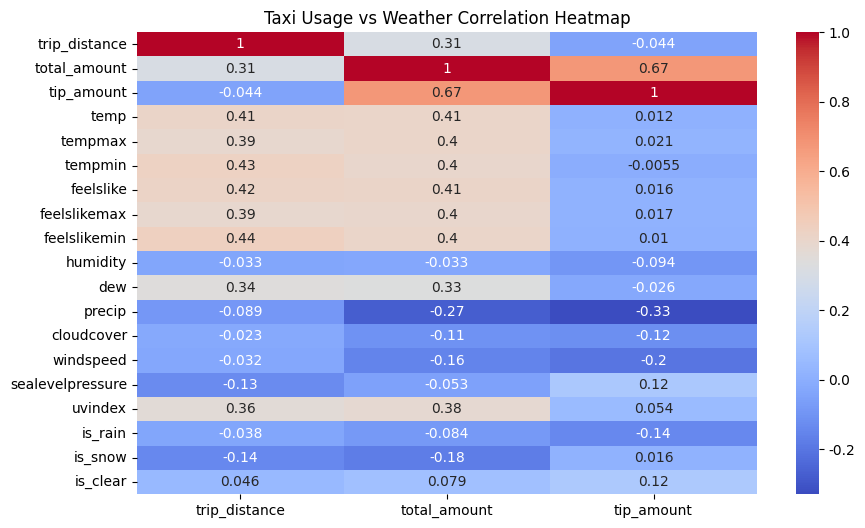

In [ ]:
# 상관관계 히트맵
plt.figure(figsize=(10, 6))
sns.heatmap(sub_corr, annot=True, cmap="coolwarm")
plt.title("Taxi Usage vs Weather Correlation Heatmap")
plt.show()

## 상관관계 분석

- total_amount & tip_amount
    - 약 0.674로 강한 상관관계를 보여줌을 알 수 있음
    - 당연하지만, 팁은 총 요금의 비율로 제공하기 때문에, 총 요금이 높을수록 팁이 높은 경향을 확인할 수 있음

- total_amount & tip_amount
    - 0.306으로 약한 상관관계를 보여줌
    - 거리가 멀수록 요금이 오름

- temp & trip_distance, total_amount
    - 둘다 약 0.41로 상관관계를 보임
    - 기온이 높을수록 이동거리와 요금이 증가하는 것을 확인할 수 잇음
        - 운행 거리가 증가하니 요금도 자엽스럽게 오름

- precip & trip_distance, total_amount, tip_amount
    - 음의 상관관계를 보임
    - 비가 많이 올수록 거리, 요금, 팁 모두 줄어드는 것을 확인할 수 있음
    - 짧은 거리를 갈 때도 택시를 타고 움직인다고 예측할 수 있음

- 바람이 많이 불때(windspeed)도 짧은 거리를 갈 때 택시를 타고 움직인다고 예측할 수 있음

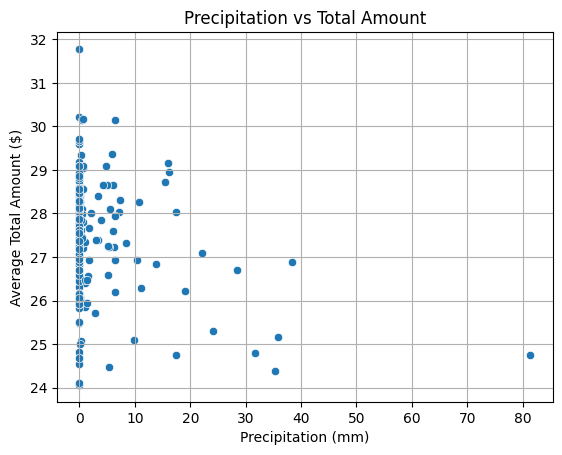

In [89]:
precip_amount_df = merged_df.select("precip", "total_amount").dropna().toPandas()

sns.scatterplot(data=precip_amount_df, x="precip", y="total_amount")
plt.title("Precipitation vs Total Amount")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Average Total Amount ($)")
plt.grid(True)
plt.show()

- 비가 많이 올 수록 요금이 적음
    - 짧은 거리를 택시로 이동하는 경우가 많다느 것을 생각해볼 수 있음

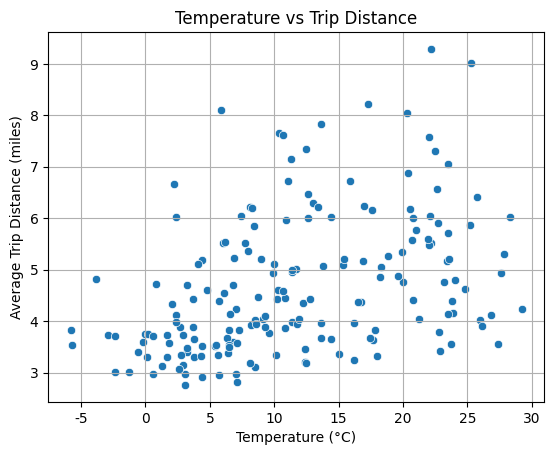

In [90]:
temp_distance_df = merged_df.select("temp", "trip_distance").dropna().toPandas()

sns.scatterplot(data=temp_distance_df, x="temp", y="trip_distance")
plt.title("Temperature vs Trip Distance")
plt.xlabel("Temperature (°C)")
plt.ylabel("Average Trip Distance (miles)")
plt.grid(True)
plt.show()

- 기온이 높아질수록 이동거리가 증가하는 것을 확인할 수 있음
    - 덥기 때문에 이동할 때 대중교통보단 택시를 이용해서 간다고 추측해볼 수 있음

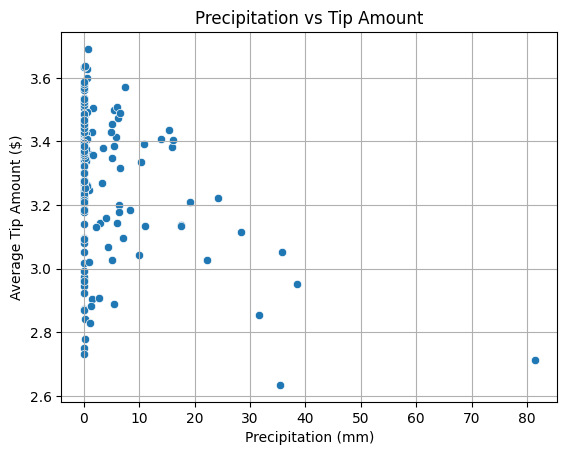

In [91]:
precip_tip_df = merged_df.select("precip", "tip_amount").dropna().toPandas()

sns.scatterplot(data=precip_tip_df, x="precip", y="tip_amount")
plt.title("Precipitation vs Tip Amount")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Average Tip Amount ($)")
plt.grid(True)
plt.show()

- 강수량이 많아질수록 팁이 적어짐
    - 택시를 타고 짧은 거리로 이동하는 손님이 많기때문에 팁도 자연스럽게 줄어듦을 추측해볼 수 있음

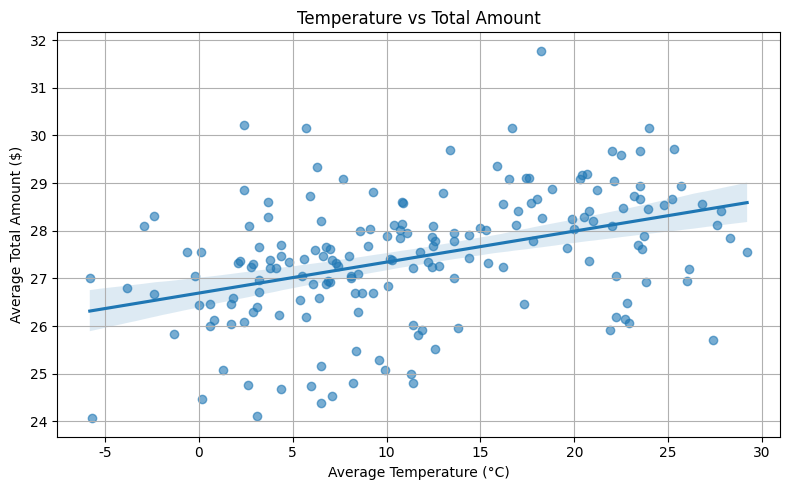

In [92]:
temp_total_df = merged_df.select("temp", "total_amount").dropna().toPandas()

plt.figure(figsize=(8, 5))
sns.regplot(data=temp_total_df, x="temp", y="total_amount", scatter_kws={"alpha":0.6})
plt.title("Temperature vs Total Amount")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Average Total Amount ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

- 기온이 높을수록 택시에 사용하는 요금이 증가하는 것을 볼 수 있음
    - 택시를 타고 움직이는 거리가 길어지기 때문에 요금도 자연스럽게 증가함을 추측해볼 수 있음

In [ ]:
# 날 수 계산
day_flags = weather_df.select(
    "pickup_date", "is_rain", "is_snow", "is_clear"
).selectExpr(
    "pickup_date",
    "stack(3, 'is_rain', is_rain, 'is_snow', is_snow, 'is_clear', is_clear) as (weather_type, flag)"
).filter("flag = true")

day_counts = day_flags.groupBy("weather_type").agg(countDistinct("pickup_date").alias("날 수"))

# 택시 이용 수
ride_flags = merged_df.select(
    "pickup_date", "is_rain", "is_snow", "is_clear"
).selectExpr(
    "pickup_date",
    "stack(3, 'is_rain', is_rain, 'is_snow', is_snow, 'is_clear', is_clear) as (weather_type, flag)"
).filter("flag = true")

ride_counts = ride_flags.groupBy("weather_type").count().withColumnRenamed("count", "택시 이용 수")

# 병합 및 1일당 평균 계산

result = day_counts.join(ride_counts, on="weather_type", how="inner")
result = result.withColumn("1일당 평균 택시 이용 수", col("택시 이용 수") / col("날 수"))

result.show(truncate=False)

+------------+-----+------------+-----------------------+
|weather_type|날 수|택시 이용 수|1일당 평균 택시 이용 수|
+------------+-----+------------+-----------------------+
|is_rain     |75   |75          |1.0                    |
|is_clear    |106  |106         |1.0                    |
|is_snow     |8    |8           |1.0                    |
+------------+-----+------------+-----------------------+



- 일반적으로 비가 올때 택시를 더 많이 탄다고 생각할 수 있는데, 의미가 있을만한 큰 차이가 없어보임